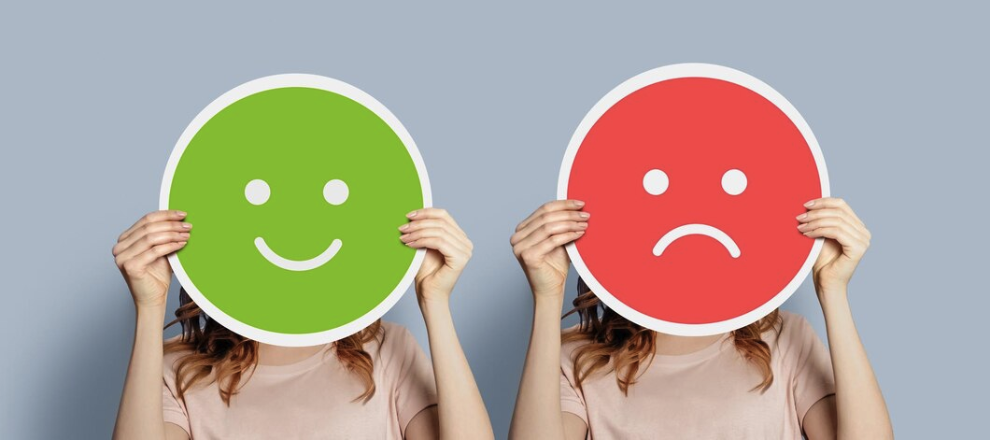



# **Facial Emotion Detection**

## **Problem Definition**

--------------
## **Context**
--------------

In the retail industry, understanding customer emotions plays a crucial role in improving customer experience, enhancing sales, and building brand loyalty. A facial emotion recognition model can be employed to achieve these goals.  Facial emotion recognition can be integrated into recommendation systems to provide personalized product recommendations based on customers' emotional states.  For instance, when a customer exhibits signs of happiness while exploring a specific product category, the system swiftly responds by curating a selection of related products or exclusive offers. This proactive approach not only augments the shopping experience but also fosters a deeper connection between the customer and the brand, resulting in heightened satisfaction and loyalty. Whether it's offering empathetic assistance during moments of uncertainty or celebrating moments of joy with personalized incentives, the model empowers retailers to forge meaningful connections that transcend transactional interactions.

----------------
## **Objective**
----------------

My objective is to predict the emotions depicted in images using Convolutional Neural Networks, with or without Transfer Learning. I will explore various CNN architectures and training strategies, evaluating their performance on the task of emotion recognition. Ultimately, I will select the model that demonstrates the highest accuracy and effectiveness in capturing emotional nuances from images.

----------------
## **Key Questions**
----------------

*  Within the data what are the key nuances that distinguish one emotion from another?
*  What metrics will be used to evaluate the performance?
*  What will be the training strategy, including batch size, learning rate, and optimization alorithm?
*  What ethical considerations need to be taken into account regarding the use of facial emotion recognition technology?
*  How will privacy concerns be addressed, particularly regarding the collection and use of facial data?
*  What are the implications of using facial data of minors?

----------------
## **Problem Formulation**
----------------

Currently the shopping experience does not adjust to the customers' emotional states. Are we able to detect cutomers' emotional state and cater their shopping experience to it?

-------------
## **Dataset**
-------------
The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [161]:
!pip install visualkeras
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.4 MB/s eta 0:00:00


In [218]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os
import cv2

from enum import Enum
import random

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from keras import backend, optimizers
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten

import visualkeras

from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# set the display format to 2 decimal places for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)

<a id="helper"></a>
### **Helper**

**Note:**
- I moved all the helper functions here so they would be easier to maintain.

In [5]:
# initializing shared constants

IMG_SIZE = 48

class Emotion(Enum):
  HAPPY = 'happy'
  SAD = 'sad'
  SURPRISE = 'surprise'
  NEUTRAL = 'neutral'

# extract class labels from Emotion Enum
CLASSES = [member.value for member in Emotion.__members__.values()]
CLASS_COUNT = len(Emotion.__members__)

In [6]:
def get_data(dir_path):
  """
  Function to read images from a directory and create a DataFrame containing
  the resized images and their corresponding categories.

  Args:
    dir_path (str): Path to directory containing data

  Returns:
    data (DataFrame): Dataframe containing data found in dir_path

  Note:
    Assumes the existence of two global variables:
    - Emotion: An enum of category names.
    - IMG_SIZE: The desired size for the resized images.
  """
  data = [] # initialize an empty list to store data

  # loop through all the categories
  for emotion in Emotion:
    category_path = os.path.join(dir_path, emotion.value)  # Get the path for the current category

    # loop through all the images in the current category
    for img_name in os.listdir(category_path):

      # get full path of image
      img_path = os.path.join(category_path, img_name)

      # read the image using OpenCV
      img_array = cv2.imread(img_path)

      # add image to data list
      data.append([img_path, img_array, emotion.value])

  # convert data to DataFrame with columns "Path", "Image" and "Category"
  return pd.DataFrame(data, columns=['Path','Image','Category'])

In [7]:
def show_category_images(emotion, data, sampleCount = 12):
  """
  Display a sample of images from a specific category.

  Args:
    emotion (enum) : Category used to filter the images
    data (DataFrame) : Dataframe used to as the source of images
    sampleCount (int) : Number of images to display.  Default is 12
  """

  # get list of images in the directory for specified category
  category_imgs = data[data['Category'] == emotion.value]['Image']

  print(f"Number of images: {category_imgs.count()}")

  # select a random sample of image file names
  samples = np.random.choice(category_imgs, sampleCount, replace=False)

  # create a new figure for plotting
  fig = plt.figure(figsize=(10, 10))

  # loop over the sample images
  for i, img in enumerate(samples):

    # add subplot
    ax = fig.add_subplot(6,4,i+1)

    # Load the image from the array
    loaded_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Resize the images to keep them consistent
    loaded_img = cv2.resize(loaded_img, (IMG_SIZE, IMG_SIZE))

    # display image
    plt.imshow(loaded_img)

    # turn off axis labels
    plt.axis('off')

    # add title
    plt.title(emotion.value)

  # show the figure
  plt.show()

In [8]:
def add_gaussian_noise(image):
  '''
  Add gaussian noise to the image.

  Args:
    image (numpy array): The image to add noise to.
  Returns:
    numpy array: The image with added noise.
  '''

  # define the mean and variance of Gaussian noise
  mean = 0
  var = np.random.randint(1,26) # randomly select variace between 1 and 25

  # generate gaussian noise
  noise = np.random.normal(mean, var**0.5, image.shape)

  # add the noise to the original image
  image = image + noise

  # clip the pixel values to be between 0 and 255 and convert pixel values to int
  return np.clip(image, 0, 255)

In [9]:
def custom_augmentation(image, add_noise=True, preprocessing_func=None):
  '''
  Perform custom augmentation on the image.

  Args:
    image (numpy array): The image to perform augmentation on.
    add_noise (bool): Whether to add Gaussian noise to the image. Default is True.
    preprocessing_func (function): A function to apply preprocessing to the image.
  Returns:
    numpy array: The augmented image.
  '''

  if add_noise:
    image = add_gaussian_noise(image)

  if preprocessing_func != None:
    image = preprocessing_func(image)

  return np.array(image)

In [10]:
def load_data(data, preprocessing_func=None, augment=False, add_noise=False, shuffle=False, color_mode = "grayscale"):
    """
    Load image data from a directory using an ImageDataGenerator.

    Args:
        data (DataFrame): DataFrame containing the image data.
        preprocessing_func (function): Function to apply custom augmentation to images.
        augment (bool): Whether to perform data augmentation. Default is False.
        add_noise (bool): Whether to add Gaussian noise to the images. Default is False.
        shuffle (bool): Whether to shuffle the data. Default is False.
        color_mode (str): Color mode for the images. Default is "grayscale".

    Returns:
        DirectoryIterator: A DirectoryIterator yielding batches of augmented images and labels.

    Note:
        Assumes the existence of the following global variables:
        - IMG_SIZE: The target size for the images.
        - CLASSES: A list of emotion categories.

    """

    rescale_value = 1.0/ 255.0 # Rescale pixel values to [0, 1]
    datagen = None

    # Create an ImageDataGenerator object for image augmentation
    if augment:
      datagen = ImageDataGenerator(rescale=rescale_value,
                                  horizontal_flip=True,
                                  vertical_flip=False, # upside down smile is a frown
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.3, 1],
                                  data_format='channels_last')
    else:
      datagen = ImageDataGenerator(rescale=rescale_value, data_format='channels_last')

    if add_noise == True or preprocessing_func != None:
      datagen.preprocessing_function = lambda x: custom_augmentation(x,
                                                                     add_noise=add_noise,
                                                                     preprocessing_func=preprocessing_func)

    # flow images in batches of 32 using datagen generator
    return datagen.flow_from_dataframe(
        dataframe=data,
        x_col='Path',
        y_col='Category',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=shuffle)

In [11]:
def get_test_data_split(data):
  """
  Gets the images and labels from all the batches in the test data.

    Args:
        data (DataFrame): DataFrame containing the image data.

    Returns:
        tuple: A tuple containing the test images and labels.

  """
  # get the total number of batches
  total_batches = len(data)

  # initialize empty lists to store all the test images and labels
  test_images = []
  test_labels = []

  # interate over all batches for test data
  for _ in range(total_batches):
    testX, testY = next(data)
    test_images.append(testX)
    test_labels.append(testY)

  # concatenate the lists of images and labels
  testX = np.concatenate(test_images)
  testY = np.concatenate(test_labels)

  return testX, testY

In [12]:
def reset():
  SEED = 42

  backend.clear_session() # Remove the model for session

  # Setting numpy random seed
  np.random.seed(SEED)

  # Setting python random seed
  random.seed(SEED)

  # Setting TensorFlow random seed
  tf.random.set_seed(SEED)

In [13]:
def plot_history(history, model_name):
  '''
  This function plots the accuracies of the model.

    Args:
      history (history object): history object of the model
      model_name(str): name of the model
  '''

  print(f'Maximum Training Accuracy Score: {max(history.history["accuracy"])*100:.2f}%')
  print(f'Maximum Validation Accuracy Score: {max(history.history["val_accuracy"])*100:.2f}%')

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

In [14]:
def plot_confusion_matrix(model):
    """
    This function prints and plots the confusion matrix.

    Args:
        model (Sequential): The trained model.
        test_labels (numpy array): The true labels of the test data.

    Note:
        Assumes the existence of the following global variables:
        - CLASSES: A list of emotion categories.
    """

    # predicting labels for the test images
    y_pred = model.predict(testX)

    # getting the highest rated predicted labels
    preds = np.argmax(y_pred, axis = 1)

    # getting the highest true labels
    y_true = np.argmax(testY, axis = 1)

    # showing the Precision, Recall, F1-score etc... for each category
    print(classification_report(y_true, preds, target_names=CLASSES))

    # plotting the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, preds, display_labels=CLASSES);

In [15]:
def get_callbacks(model_name):
  """
  This function returns the callbacks for the model.

    Args:
        model_name (str): Name of the model.

    Returns:
        list: A list of callbacks.
  """
  # stop the training when a validation accuracy has stopped improving
  es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

  # save the best model during training
  mc = ModelCheckpoint(model_name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

  return [es, mc]

In [433]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    '''
    Generates class activation heatmap for a given image

    Args:
    img_array (numpy.ndarray): Input image array
    model (keras.Model): Keras model
    last_conv_layer_name (str): Name of the last convolutional layer

    Returns:
    numpy.ndarray: Class activation heatmap
    '''

    # create a new model that maps the input image to the output of the last convolutional layer and the model's predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # get the output of the last convolutional layer and the model's predictions for the input image
        last_conv_layer_output, preds = grad_model(img_array)

        pred_index = tf.argmax(preds[0])

        # extract the predicted probability of the target class
        class_channel = preds[:, pred_index]

    # compute the gradients of the target class with respect to the output of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # compute the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the last convolutional layer output by the corresponding gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

    # remove negative values and normalize the heatmap
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # convert the heatmap to a NumPy array and return it
    return heatmap.numpy()

In [388]:
def get_test_image_arrays():
  '''
  Gets the test image arrays and their corresponding labels.

  Returns:
    numpy.ndarray: Class activation heatmap

  Note:
    Assumes the existence of the following global variables:
    - testing_data: A pandas DataFrame containing the test data.
  '''
  # get random image from each category
  happy_row = testing_data[testing_data['Category'] == 'happy'].sample(n=1).iloc[0]
  neutral_row = testing_data[testing_data['Category'] == 'neutral'].sample(n=1).iloc[0]
  sad_row = testing_data[testing_data['Category'] == 'sad'].sample(n=1).iloc[0]
  surprise_row = testing_data[testing_data['Category'] == 'surprise'].sample(n=1).iloc[0]

  # initialize a list of categories
  image_titles = [happy_row['Category'], neutral_row['Category'], sad_row['Category'], surprise_row['Category']]

  # initialize array of images
  images = [happy_row['Image'], neutral_row['Image'], sad_row['Image'], surprise_row['Image']]

  return images, image_titles

In [436]:
def visualize_important_features(model, last_conv_layer_name):
    '''
    Generates class activation heatmap for a given image

    Args:
    model (keras.Model): Keras model
    last_conv_layer_name (str): Name of the last convolutional layer
    pred_index (int): Index of the predicted class

    Returns:
    numpy.ndarray: Class activation heatmap
    '''

    # get test image arrays and their corresponding labels
    images, image_titles = get_test_image_arrays()

    # create a copy of the model
    model_dup = model

    # Remove last layer's softmax
    model_dup.layers[-1].activation = None

    # Rendering
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(6, 5))

    for i, title in enumerate(image_titles):
        # prepare image
        img_array = np.expand_dims(images[i], axis=0)

        # get model predictions on image
        preds = model_dup.predict(img_array, verbose=0)

        # generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model_dup, last_conv_layer_name)

        # rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # use jet colormap to colorize heatmap
        jet = mpl.colormaps["jet"]

        # use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # create an image with RGB colorized heatmap
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((images[i].shape[1], images[i].shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + images[i]
        superimposed_img = keras.utils.array_to_img(superimposed_img)

        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(superimposed_img)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [16]:
ZIP_PATH = '/content/drive/MyDrive/MIT/Capstone Project/Facial_emotion_images.zip'

# unzipping data file to google colab
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall()

In [17]:
training_data = get_data('/content/Facial_emotion_images/train')
print(f'Training Data has {training_data.shape[0]} rows and {training_data.shape[1]} columns')

img_size = training_data.iloc[0]['Image'].shape[:2]
img_channel = training_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Training Data has 15109 rows and 3 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


In [18]:
testing_data = get_data('/content/Facial_emotion_images/test')
print(f'Testing Data has {testing_data.shape[0]} rows and {testing_data.shape[1]} columns')

img_size = testing_data.iloc[0]['Image'].shape[:2]
img_channel = training_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Testing Data has 128 rows and 3 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


In [19]:
validation_data = get_data('/content/Facial_emotion_images/validation')
print(f'Validation Data has {validation_data.shape[0]} rows and {validation_data.shape[1]} columns')

img_size = validation_data.iloc[0]['Image'].shape[:2]
img_channel = validation_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Validation Data has 4977 rows and 3 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

### **Happy**

**Observations and Insights:**


*   There are 3976 happy images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Happy images generally show a face with a smile.
*   Happy images generally show a face and teeth but not always.
*   It would be interesting if the models pick up on the happiness in the eyes but that would be hard to articulate.

Number of images: 3976


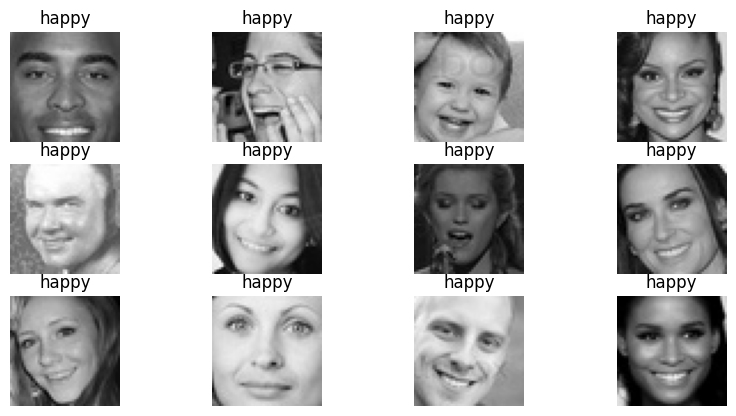

In [20]:
show_category_images(Emotion.HAPPY, training_data)

### **Sad**

**Observations and Insights:**


*   There are 3982 sad images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Sad images generally show a face with turned down lips, and or crying.
*   It would be interesting if the models pick up on the sadness in the eyes but that would be hard to articulate.

Number of images: 3982


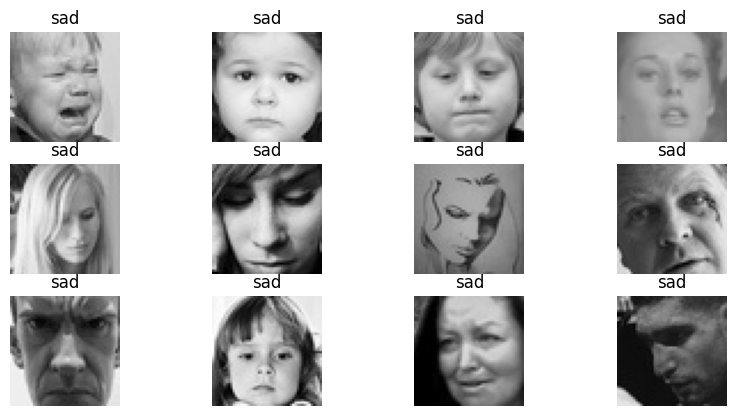

In [21]:
show_category_images(Emotion.SAD, training_data)

### **Neutral**

**Observations and Insights:**


*   There are 3978 neutral images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Some of the neutral images look like other emotions like sad and angry.  It will interesting to see the the models have an issue distinguishing between neutral and other emotions like sad.
*   Neutral images look like emotionless faces if not sad.

Number of images: 3978


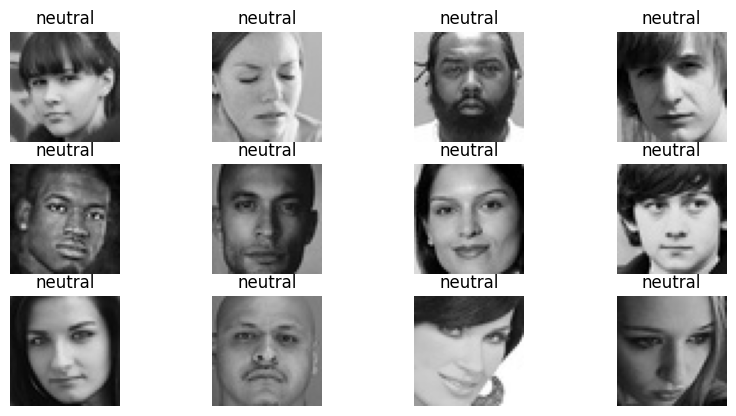

In [22]:
show_category_images(Emotion.NEUTRAL, training_data)

### **Surprised**

**Observations and Insights:**


*   There are 3173 surprised images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   A lot of the surprised images have open mouths, but not all of them.  It will be interesting to see if the model zeros in on that.
*   It would be interesting if the models pick up on the surprise in the eyes but that would be hard to articulate.

Number of images: 3173


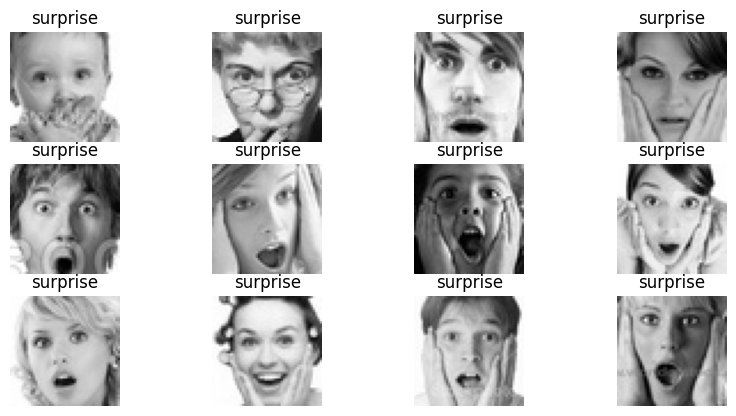

In [23]:
show_category_images(Emotion.SURPRISE, training_data)

## **Checking Distribution of Classes**

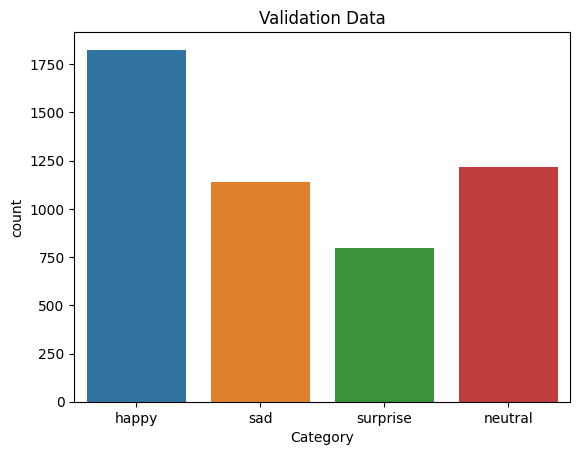

In [24]:
sns.countplot(x='Category', data=validation_data, hue="Category", legend=False);
plt.title("Validation Data")
plt.show()

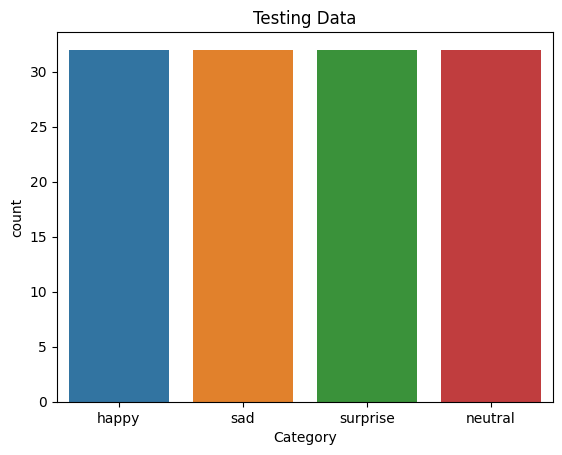

In [25]:
sns.countplot(x='Category', data=testing_data, hue="Category", legend=False);
plt.title("Testing Data")
plt.show()

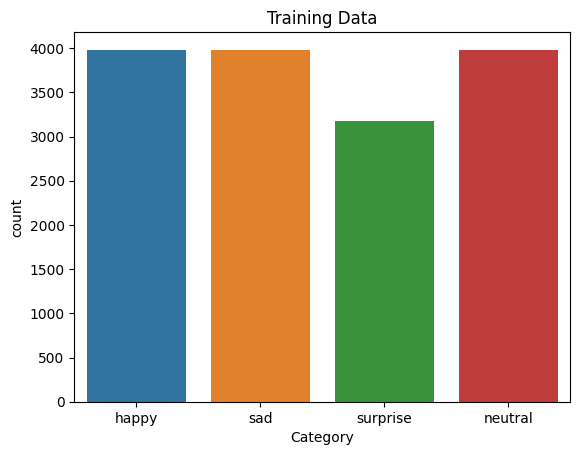

In [26]:
sns.countplot(x='Category', data=training_data, hue="Category", legend=False);
plt.title("Training Data")
plt.show()

**Observations and Insights:**

The data is not highly imbalanced, but the number of images for the **surprise** emotion is less than the other emotions.  Because of this slight imbalance I will use evaluation methods like...


  *   **Confusion Matrix** which will provides a detailed breakdown of correct and incorrect classifications.
  *   **Accuracy** which will evaluate the test data to see how many the model got correct.
  *   **F1-Score** which will give me an indication of how well the model correctly classifies the emotions while minizing false negatives and false postives i.e. incorrectly classifying the emotions.

**Think About It:**
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
  
  - The data is slightly imabalanced wish the surpised category a little less the the other emotions.  This may cause the model to select the majority classes more than the minority one.  I will keep an eye out for this when testing the models.
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

  - We can check the image demensions to make sure they are consistent.

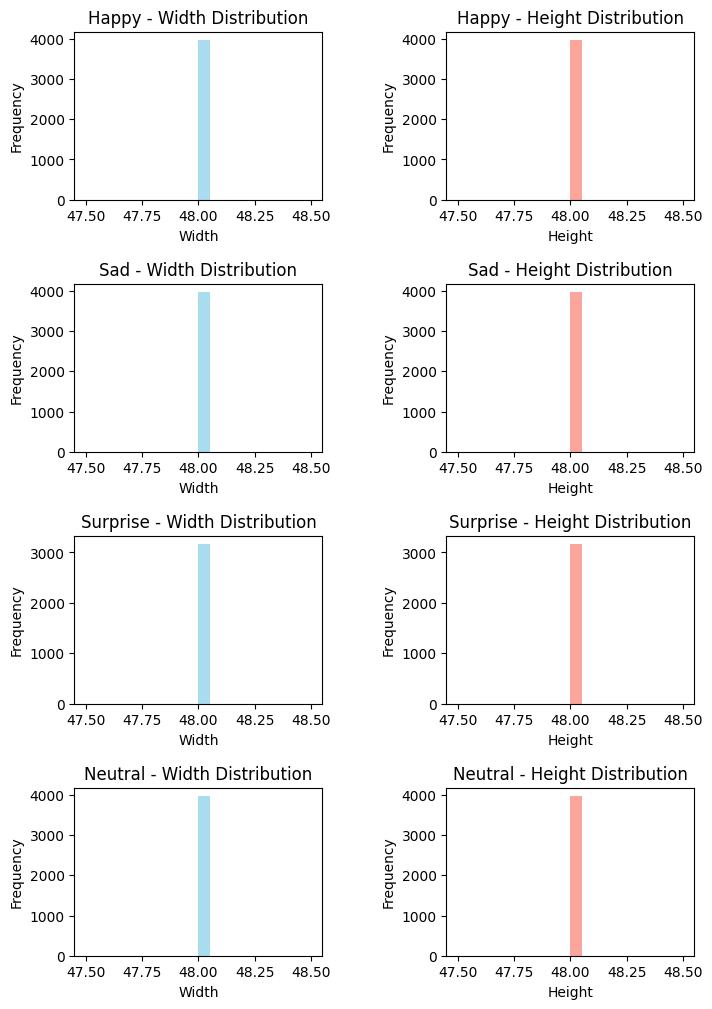

In [27]:
# Calculate width and height for each image
training_data['width'] = training_data['Image'].apply(lambda x: x.shape[1])  # Width of the image
training_data['height'] = training_data['Image'].apply(lambda x: x.shape[0])  # Height of the image

# Plot histogram of width and height for each category
categories = training_data['Category'].unique()
num_categories = len(categories)

fig, axes = plt.subplots(nrows=num_categories, ncols=2, figsize=(8, 3*num_categories))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, category in enumerate(categories):
    category_data = training_data[training_data['Category'] == category]
    axes[i, 0].hist(category_data['width'], bins=20, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'{category.capitalize()} - Width Distribution')
    axes[i, 0].set_xlabel('Width')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(category_data['height'], bins=20, color='salmon', alpha=0.7)
    axes[i, 1].set_title(f'{category.capitalize()} - Height Distribution')
    axes[i, 1].set_xlabel('Height')
    axes[i, 1].set_ylabel('Frequency')

plt.show()

# Clean up data
training_data.drop(columns=['width', 'height'], inplace=True)

**Observations and Insights:**


*   All the training images are consistently 48x48

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

*I created helper functions located in the [helper](#helper) section that assist in creating the data loaders.  I will be using them throughout the model building.*



In [305]:
train_grayscale_set = load_data(training_data, add_noise=True, augment=True, shuffle=True);
test_grayscale_set = load_data(testing_data);
validation_grayscale_set = load_data(validation_data);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_grayscale_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?

  - Yes, the Convulational Neural Networks is the correct approach because of the convolutional and pooling layers.  These layers allows the model to capture heirarcheis of features (from simple edges to more complex patterns) within the images more effectively.
* What are the advantages of CNNs over ANNs and are they applicable here?

  - CNNs are designed to understand images better
  - CNNs lean faster than ANNs
  - CNNs are less prone to overfitting



### **Creating the Base Neural Network**

#### Greyscale Color Mode

In [365]:
# Initializing the Convolutional Neural Network
base_cnn_grayscale_model = Sequential([
    # Convolutional layer with 256 filters, each of size 5x5, using ReLU activation
    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)),
    # Max pooling layer with pool size 2x2 and stride 2x2
    MaxPooling2D(strides=(2,2)),
    # Dropout layer to prevent overfitting by randomly dropping 25% of the units
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Flatten(),

    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the first layer
    Dense(32, activation='relu'),  # A fully connected with 42 nodes as the second layer which is reduced to prevent overfitting
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

# Print the model summary
base_cnn_grayscale_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 48, 48, 256)       6656      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 256)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)        147520    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 64)       

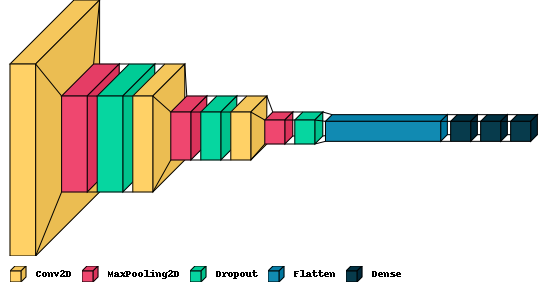

In [366]:
# Visualize architecture
visualkeras.layered_view(base_cnn_grayscale_model, legend=True)

##### **Compiling and Training the Model**

In [367]:
best_base_cnn_grayscale_model = "best_base_cnn_grayscale_model.h5"

# compile the model
base_cnn_grayscale_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# get call backs
es, mc = get_callbacks(best_base_cnn_grayscale_model)

# fit the model to the train dataset
base_cnn_grayscale_model_history = base_cnn_grayscale_model.fit(train_grayscale_set,
                                            validation_data = validation_grayscale_set,
                                            verbose = 1,
                                            epochs = 100,
                                            callbacks=[es, mc])

Epoch 1/100
472/473 [============================>.] - ETA: 0s - loss: 1.3732 - accuracy: 0.2927
Epoch 1: val_accuracy improved from -inf to 0.37151, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 21s 40ms/step - loss: 1.3732 - accuracy: 0.2924 - val_loss: 1.3471 - val_accuracy: 0.3715
Epoch 2/100
  3/473 [..............................] - ETA: 17s - loss: 1.3355 - accuracy: 0.3438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/473 [============================>.] - ETA: 0s - loss: 1.3432 - accuracy: 0.3294
Epoch 2: val_accuracy improved from 0.37151 to 0.38979, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 19s 40ms/step - loss: 1.3432 - accuracy: 0.3296 - val_loss: 1.2620 - val_accuracy: 0.3898
Epoch 3/100
472/473 [============================>.] - ETA: 0s - loss: 1.2970 - accuracy: 0.3730
Epoch 3: val_accuracy improved from 0.38979 to 0.41893, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 19s 39ms/step - loss: 1.2969 - accuracy: 0.3731 - val_loss: 1.2257 - val_accuracy: 0.4189
Epoch 4/100
472/473 [============================>.] - ETA: 0s - loss: 1.2665 - accuracy: 0.3964
Epoch 4: val_accuracy improved from 0.41893 to 0.46896, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 19s 40ms/step - loss: 1.2665 - accuracy: 0.3965 - val_loss: 1.1801 - val_accuracy: 0.4690
Epoch 5

##### **Model Evaluation**

In [368]:
# load the best model
base_cnn_grayscale_model.load_weights(best_base_cnn_grayscale_model)

Maximum Training Accuracy Score: 61.40%
Maximum Validation Accuracy Score: 69.56%


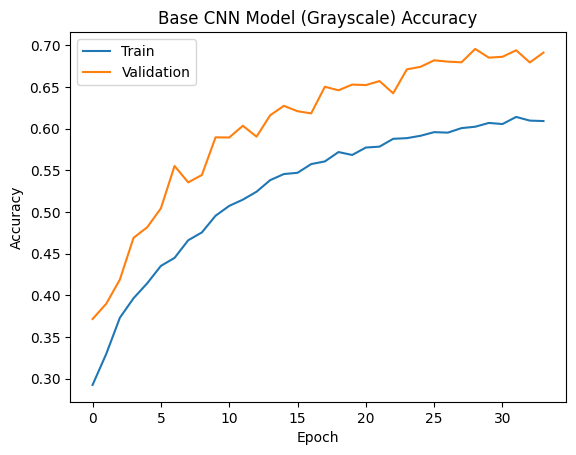

In [369]:
plot_history(base_cnn_grayscale_model_history, "Base CNN Model (Grayscale)")

##### **Evaluating the Model on the Test Set**

In [370]:
# get the metric value
accuracy = base_cnn_grayscale_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.7519 - accuracy: 0.6797 - 31ms/epoch - 8ms/step
Test Accuracy: 67.97%


**Observations and Insights:**

- The grayscale CNN model has given an accuracy of about 68% on the the test data (depending on the run).
-  Because of the added augmentation to the training data and the early stopping the model is not overfitting.  Which is good.
- The steady rise of the validation accuracy over the training accuracy shows that the performance is good.
- Best epoch was 29 with 70% validation accuracy

##### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       happy       0.69      0.75      0.72        32
         sad       0.61      0.69      0.65        32
    surprise       0.52      0.47      0.49        32
     neutral       0.93      0.81      0.87        32

    accuracy                           0.68       128
   macro avg       0.69      0.68      0.68       128
weighted avg       0.69      0.68      0.68       128



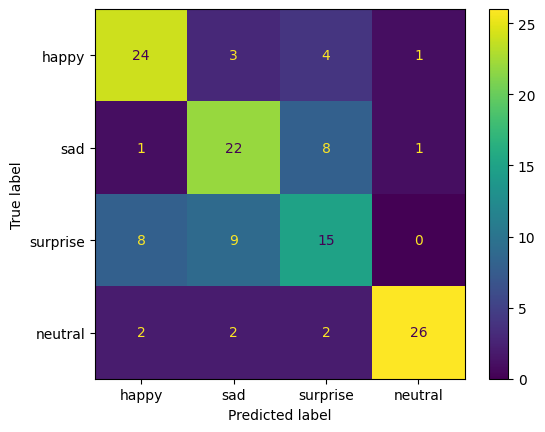

In [371]:
plot_confusion_matrix(base_cnn_grayscale_model)

**Observations and Insights:**

*   The model seems to be the surest about neutral faces with highest f1-score.  This was unexpected since this was one of the most vague emotions.
*  The model was the least sure about the surprise emotion.  It often confused it with the happy and sad emotions.

#### RGB Color Mode

*Fitting the RGB datasets to see if I get better accuracies.*

In [373]:
reset()

In [374]:
train_rgb_set = load_data(training_data, add_noise=True, augment=True, shuffle=True, color_mode = 'rgb');
test_rgb_set = load_data(testing_data, color_mode = 'rgb');
validation_rgb_set = load_data(validation_data, color_mode = 'rgb');

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_rgb_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


In [375]:
# Initializing the Convolutional Neural Network
base_cnn_rgb_model = Sequential([
    # Convolutional layer with 256 filters, each of size 5x5, using ReLU activation
    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    # Max pooling layer with pool size 2x2 and stride 2x2
    MaxPooling2D(strides=(2,2)),
    # Dropout layer to prevent overfitting by randomly dropping 25% of the units
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Flatten(),

    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the first layer
    Dense(32, activation='relu'),  # A fully connected with 42 nodes as the second layer which is reduced to prevent overfitting
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

# Print the model summary
base_cnn_rgb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       19456     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

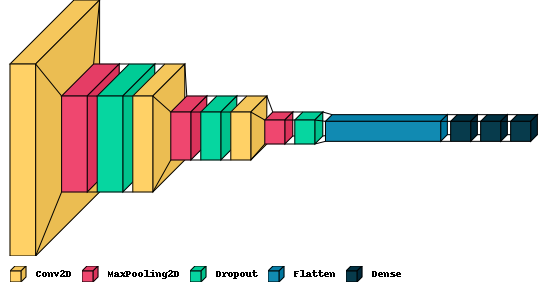

In [376]:
# Visualize architecture
visualkeras.layered_view(base_cnn_rgb_model, legend=True)

##### **Compiling and Training the Model**

In [379]:
best_base_cnn_rgb_model = "best_base_cnn_rgb_model.h5"

base_cnn_rgb_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# get call backs
es, mc = get_callbacks(best_base_cnn_rgb_model)

# Fit the model to the train dataset
base_cnn_rgb_model_history = base_cnn_rgb_model.fit(train_rgb_set,
                                            validation_data = validation_rgb_set,
                                            verbose = 1,
                                            epochs = 100,
                                            callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.5986
Epoch 1: val_accuracy improved from -inf to 0.67892, saving model to best_base_cnn_rgb_model.h5
473/473 [==============================] - 31s 62ms/step - loss: 0.9370 - accuracy: 0.5986 - val_loss: 0.7795 - val_accuracy: 0.6789
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 0.9229 - accuracy: 0.6055
Epoch 2: val_accuracy did not improve from 0.67892
473/473 [==============================] - 29s 62ms/step - loss: 0.9229 - accuracy: 0.6055 - val_loss: 0.8124 - val_accuracy: 0.6558
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.6036
Epoch 3: val_accuracy did not improve from 0.67892
473/473 [==============================] - 29s 62ms/step - loss: 0.9214 - accuracy: 0.6036 - val_loss: 0.7817 - val_accuracy: 0.6745
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.6046
Epoch 4: val_ac

##### **Model Evaluation**

In [380]:
# load the best model
base_cnn_rgb_model.load_weights(best_base_cnn_rgb_model)

Maximum Training Accuracy Score: 59.75%
Maximum Validation Accuracy Score: 67.81%


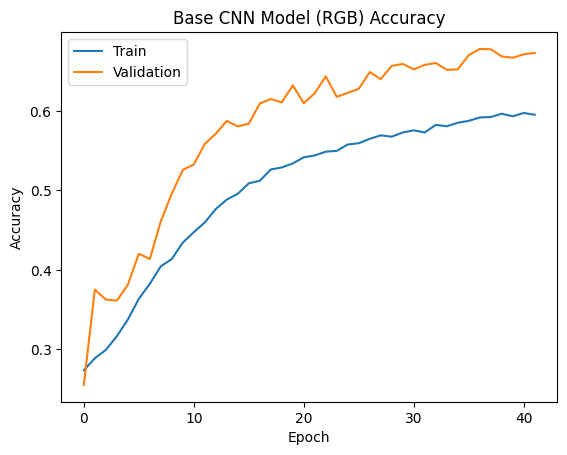

In [46]:
plot_history(base_cnn_rgb_model_history, "Base CNN Model (RGB)")

##### **Evaluating the Model on the Test Set**

In [381]:
# get the accuracy value
accuracy = base_cnn_rgb_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.6964 - accuracy: 0.7266 - 32ms/epoch - 8ms/step
Test Accuracy: 72.66%


**Observations and Insights:**

- The RGB CNN model has given an accuracy of ~72% on the the test data (depending on the run).
- Setting the color mode to RGB **did** improved the accuracy slightly.
- Early stopping stopped before the model began to overfit.
- Best epoch was 12 with 68% validation accuracy which is slightly less than the CNN grayscale models best validation accuracy of 70%.

##### **Classification Report and Confusion Matrix for Test Predictions**


4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       happy       0.77      0.84      0.81        32
         sad       0.67      0.62      0.65        32
    surprise       0.63      0.59      0.61        32
     neutral       0.82      0.84      0.83        32

    accuracy                           0.73       128
   macro avg       0.72      0.73      0.72       128
weighted avg       0.72      0.73      0.72       128



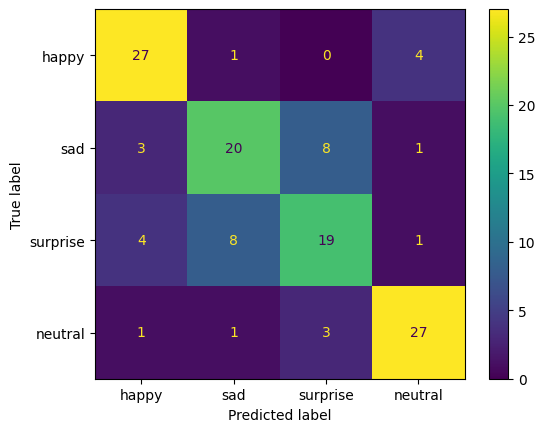

In [382]:
plot_confusion_matrix(base_cnn_rgb_model)

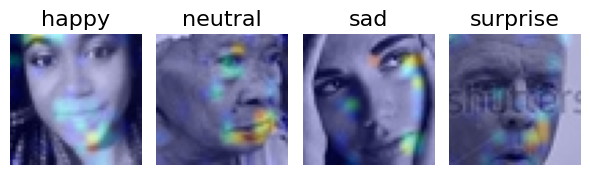

In [395]:
visualize_important_features(base_cnn_rgb_model, 'conv2d_2')

**Observations and Insights:**

*   Like the grayscale model the CNN RGB model seems to be the surest about neutral emotions with highest f1-score.
*  The model seems to confuse surprise emotions with sad emotion which if you look at the eyes in those images it's kind of understanble.
*  The model seems to focus on the eyes and the mouths for the most part.  This is good for making sure the model is not focuesd on something unexpected.



### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [396]:
reset()

In [397]:
# Initializing the Convolutional Neural Network
cnn_model_2 = Sequential([
    # Convolutional layer with 256 filters, each of size 3x3, using ReLU activation
    Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    LeakyReLU(alpha=0.1), # adding non-linearity and mitigage dying ReLU problem
    Conv2D(64, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),
    Flatten(), # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Dense(64, activation='relu'),  # a fully connected with 64 nodes as the dense layer
    Dense(32, activation='relu'),  # a fully connected with 32 nodes as the dense layer
    Dense(16, activation='relu'),  # a fully connected with 16 nodes as the dense layer
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       7168      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        147520    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                        

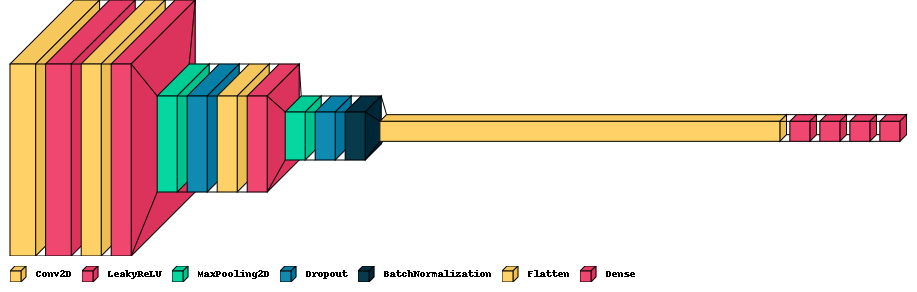

In [398]:
# Visualize architecture
visualkeras.layered_view(cnn_model_2, legend=True)

#### **Compiling and Training the Model**

In [53]:
best_cnn_model = "best_cnn_model.h5"

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_cnn_model)

# Fit the model to the train dataset
cnn_model_history = cnn_model_2.fit(train_rgb_set,
                                  validation_data = validation_rgb_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.2855
Epoch 1: val_accuracy improved from -inf to 0.35785, saving model to best_cnn_model.h5
473/473 [==============================] - 33s 63ms/step - loss: 1.3854 - accuracy: 0.2855 - val_loss: 1.3351 - val_accuracy: 0.3578
Epoch 2/100
  2/473 [..............................] - ETA: 29s - loss: 1.3966 - accuracy: 0.2969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.3704 - accuracy: 0.2994
Epoch 2: val_accuracy did not improve from 0.35785
473/473 [==============================] - 30s 63ms/step - loss: 1.3704 - accuracy: 0.2994 - val_loss: 1.3472 - val_accuracy: 0.3514
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.3659 - accuracy: 0.2986
Epoch 3: val_accuracy did not improve from 0.35785
473/473 [==============================] - 30s 62ms/step - loss: 1.3659 - accuracy: 0.2986 - val_loss: 1.3488 - val_accuracy: 0.3468
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.3063
Epoch 4: val_accuracy did not improve from 0.35785
473/473 [==============================] - 30s 63ms/step - loss: 1.3634 - accuracy: 0.3063 - val_loss: 1.3547 - val_accuracy: 0.3438
Epoch 5/100
473/473 [==============================] - ETA: 0s - loss: 1.3597 - accuracy: 0.3143
Epoch 5: val_accuracy did not improve from 0.35785
473/473 [============

#### **Model Evaluation**

In [399]:
# load the best model
cnn_model_2.load_weights(best_cnn_model)

Maximum Training Accuracy Score: 61.80%
Maximum Validation Accuracy Score: 68.15%


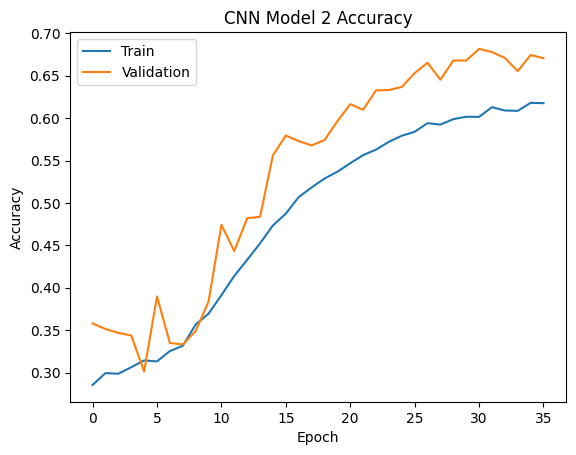

In [55]:
plot_history(cnn_model_history, "CNN Model 2")

#### **Evaluating the Model on the Test Set**

In [56]:
# get the accuracy value
accuracy = cnn_model_2.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.7589 - accuracy: 0.6562 - 35ms/epoch - 9ms/step
Test Accuracy: 65.62%


**Observations and Insights:**

- The CNN model has an accuracy of 66% on the test data.  Which is on par with the previous models.
- The validation data accuracy is above the training data accuracy which is a good sign that the model will generalize well on unseen data.
- The best epoch was #31 which had a validation accuracy of 68%.
- So far this is the best performing model is the RGB model although this model is more layered.

#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       happy       0.70      0.88      0.78        32
         sad       0.52      0.53      0.52        32
    surprise       0.48      0.44      0.46        32
     neutral       0.96      0.78      0.86        32

    accuracy                           0.66       128
   macro avg       0.66      0.66      0.66       128
weighted avg       0.66      0.66      0.66       128



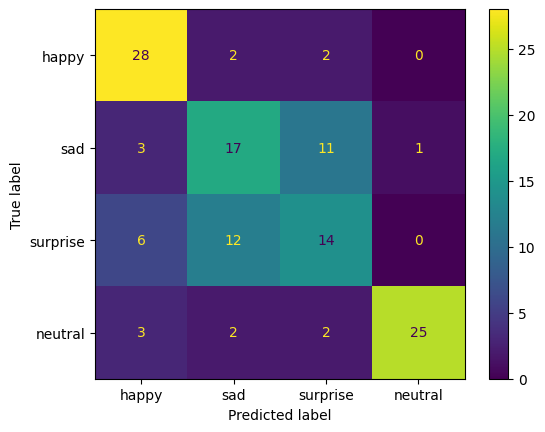

In [57]:
plot_confusion_matrix(cnn_model_2)

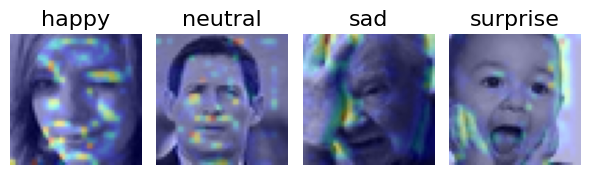

In [400]:
visualize_important_features(cnn_model_2, 'conv2d_2')

**Observations and Insights:**

*  The model is the surest about the neutral emotion closely followed by the happy emotion.
*  The model confuses the surprise emotion with happy emotion just as the previous models.  I'm getting more convinced that it has something to do with the eyes.
*  The model shows that it is focused on more parts of the face than the previous one.  One interesting thing is in the surprise image the model seems to be focused on the hands.



## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?

  The models performed well. The best performing model was the RGB model. Augemented the training data in-term giving the model more data to train on has prevented overfitting. Also early stopping has helped in getting the best version of the model before it began to overfit.  I will like to see the accuracy increase so maybe more layers will help with that.
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?


| Model      | Training Data Accuracy | Validation Data Accuracy | Test Data Accuracy |
| :--------  | :------------------: | :------------------:| :------------:|
| Grayscale Model  | 61%                 | 70%            | 68%           |
| RGB Model       | 60%                 | 68%             | 73%           |
| CNN Model 2| 62%                 | 68%                 | 66%            |


   > As you can see in the above table, the **RGB** color mode model performed *slightly* better on the test data.  Maybe there are some very subtle color variations that can't been seen.  Another thing I noticed that I was getting better accurancies with 2nd CNN model only when I used the grayscale dataset.




## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

## **VGG16 Model**

#### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

### **Importing the VGG16 Architecture**

In [58]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [420]:
train_set = load_data(training_data, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True, preprocessing_func=preprocess_input_vgg16);
test_set = load_data(testing_data, color_mode = 'rgb');
validation_set = load_data(validation_data, color_mode = 'rgb', preprocessing_func=preprocess_input_vgg16);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [60]:
reset()

In [409]:
# by setting include_top = False the model will be imported without the fully-connected layers
base_vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_vgg_model.trainable = False  # freeze the layers in the base VGG16 model to prevent them from being updated during training
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

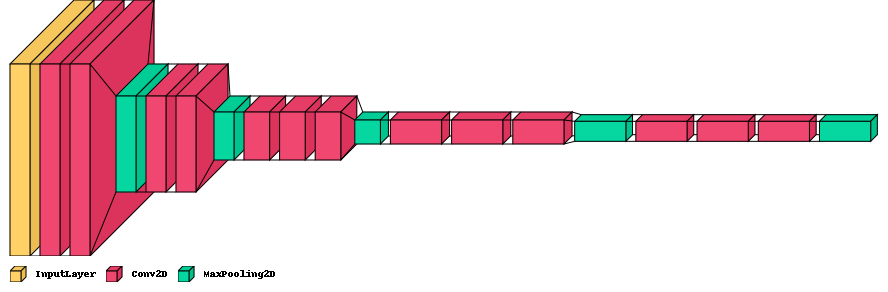

In [410]:
# Visualize architecture
visualkeras.layered_view(base_vgg_model, legend=True)

In [412]:
vgg_model = Sequential([
    base_vgg_model,
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          294976    
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)               

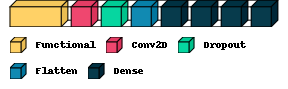

In [413]:
# Visualize architecture
visualkeras.layered_view(vgg_model, legend=True)

#### **Compiling and Training the VGG16 Model**

In [414]:
best_vgg_model = "best_vgg_model.h5"

# Compile model
vgg_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_vgg_model)

# Fit the model to the train dataset
vgg_model_history = vgg_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.2975 - accuracy: 0.3678
Epoch 1: val_accuracy improved from -inf to 0.42576, saving model to best_vgg_model.h5
473/473 [==============================] - 32s 63ms/step - loss: 1.2975 - accuracy: 0.3678 - val_loss: 1.2108 - val_accuracy: 0.4258
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.2461 - accuracy: 0.4237
Epoch 2: val_accuracy improved from 0.42576 to 0.47900, saving model to best_vgg_model.h5
473/473 [==============================] - 30s 62ms/step - loss: 1.2461 - accuracy: 0.4237 - val_loss: 1.1751 - val_accuracy: 0.4790
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.2239 - accuracy: 0.4407
Epoch 3: val_accuracy improved from 0.47900 to 0.50874, saving model to best_vgg_model.h5
473/473 [==============================] - 29s 62ms/step - loss: 1.2239 - accuracy: 0.4407 - val_loss: 1.1358 - val_accuracy: 0.5087
Epoch 4/100
473/473 [======================

#### **Evaluating the VGG16 model**

In [415]:
# load the best model
vgg_model.load_weights(best_vgg_model)

Maximum Training Accuracy Score: 47.26%
Maximum Validation Accuracy Score: 53.12%


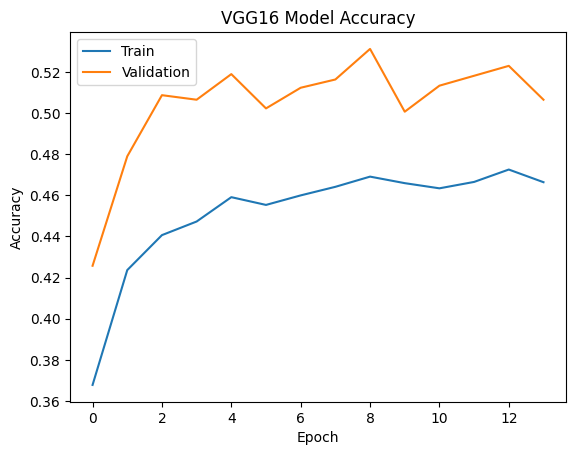

In [416]:
plot_history(vgg_model_history, "VGG16 Model")

In [417]:
# get the accuracy value
accuracy = vgg_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 1.1490 - accuracy: 0.4844 - 44ms/epoch - 11ms/step
Test Accuracy: 48.44%


**Observations and Insights:**

- The VGG model has an accuracy of 48% on the test data.  Decreasing from the RGB model's 73%.
- This model is not performing as well as the CNN models.

#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       happy       0.40      0.59      0.48        32
         sad       0.31      0.28      0.30        32
    surprise       0.54      0.47      0.50        32
     neutral       0.79      0.59      0.68        32

    accuracy                           0.48       128
   macro avg       0.51      0.48      0.49       128
weighted avg       0.51      0.48      0.49       128



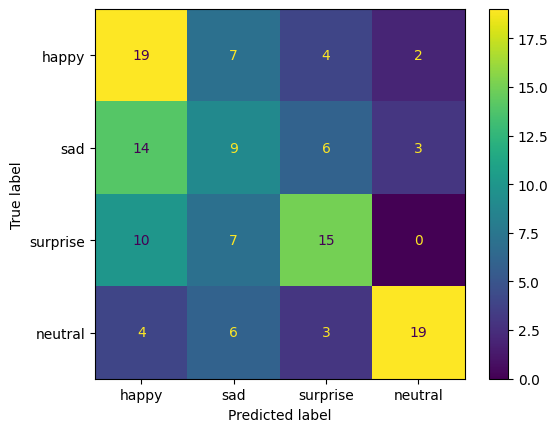

In [418]:
plot_confusion_matrix(vgg_model)

**Observations and Insights:**

* Like the previous models, the model is most sure about the neutral emotions.
* And like the model the model confuses surprise emotion with the happy emotion.
* The sad emotion has the lowest f1-score.

**Think About It:**

- What do you infer from the general trend in the training performance?
  - Although the VGG16 is good at picking out what images are, it may not be as good understanding emotions on faces.
  - Maybe a more fully connected layers will help.
  - Maybe changing the optimization and/or acivation functions will help.
  - Maybe chaning the learning rate will help.
  - Looks like the CNN model is outperforming all the other models on the validation data.  I would have predicted VGG would be the top performer, but it is not.  It will be interesting to see that happens with the next models.
- Is the training accuracy consistently improving?
  - No, the training data is dropped from 68% to 47%.
- Is the validation accuracy also improving similarly?
  - No the validation accuracy is not improving from the base RGB CNN model while it decreased from 68% to 53%.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

### **Model 2 Building**

- Adding LeakyRelu layers
- Changing the Optimization Function to SGD
- Using the default learning rate

In [71]:
reset()

In [72]:
# by setting include_top = False the model will be imported without the fully-connected layers
base_vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_vgg_model.trainable = False  # freeze the layers in the base VGG16 model to prevent them from being updated during training
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

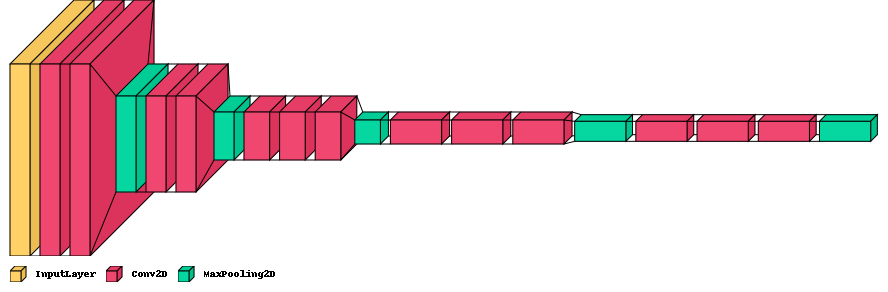

In [73]:
visualkeras.layered_view(base_vgg_model, legend=True)

In [74]:
vgg_model_2 = Sequential([
    base_vgg_model,
    GlobalAveragePooling2D(),
    LeakyReLU(alpha=0.1),
    Flatten(),
    Dense(512, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(32, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])


# print a summary of the model architecture
vgg_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                        

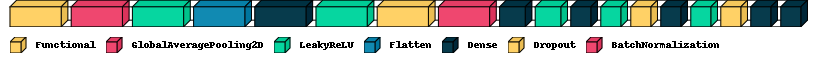

In [75]:
visualkeras.layered_view(vgg_model_2, legend=True)

#### **Compiling and Training the VGG16 Model**

In [77]:
best_vgg_2_model = "best_vgg_2_model.h5"

# compile model
vgg_model_2.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_vgg_2_model)

# Fit the model to the train dataset
vgg_model_2_history = vgg_model_2.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.4039 - accuracy: 0.2618
Epoch 1: val_accuracy improved from -inf to 0.29998, saving model to best_vgg_2_model.h5
473/473 [==============================] - 33s 66ms/step - loss: 1.4039 - accuracy: 0.2618 - val_loss: 1.3741 - val_accuracy: 0.3000
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.3863 - accuracy: 0.2688
Epoch 2: val_accuracy improved from 0.29998 to 0.30681, saving model to best_vgg_2_model.h5
473/473 [==============================] - 31s 66ms/step - loss: 1.3863 - accuracy: 0.2688 - val_loss: 1.3667 - val_accuracy: 0.3068
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.2800
Epoch 3: val_accuracy improved from 0.30681 to 0.31183, saving model to best_vgg_2_model.h5
473/473 [==============================] - 31s 66ms/step - loss: 1.3784 - accuracy: 0.2800 - val_loss: 1.3575 - val_accuracy: 0.3118
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.3695 - accuracy: 0.2893
Epoch 4: val_accuracy improved from 0.31183 to 0.31907, saving model to best_vgg_2_model.h5
473/473 [==============================] - 31s 66ms/step - loss: 1.3695 - accuracy: 0.2893 - val_loss: 1.3483 - val_accuracy: 0.3191
Epoch 5/100
473/473 [=========================

#### **Evaluating 2nd VGG16 model**

In [78]:
# load the best model
vgg_model_2.load_weights(best_vgg_2_model)

Maximum Training Accuracy Score: 42.20%
Maximum Validation Accuracy Score: 47.04%


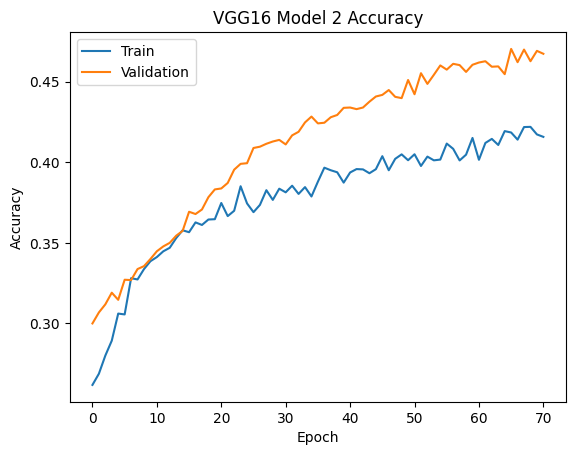

In [79]:
plot_history(vgg_model_2_history, "VGG16 Model 2")

In [ ]:
# get the accuracy value
accuracy = vgg_model_2.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.6818 - accuracy: 0.7031 - 85ms/epoch - 21ms/step
Test Accuracy: 70.31%


**Observations and Insights:**

- The VGG model has an accuracy of 70% on the test data.  Increasing from the first VGG model's 51%.
- Alhthough the model performed well on the test data it is the lowest performing model when it comes to the validation data.

#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       happy       0.46      0.59      0.52        32
         sad       0.35      0.38      0.36        32
    surprise       0.35      0.19      0.24        32
     neutral       0.61      0.69      0.65        32

    accuracy                           0.46       128
   macro avg       0.45      0.46      0.44       128
weighted avg       0.45      0.46      0.44       128



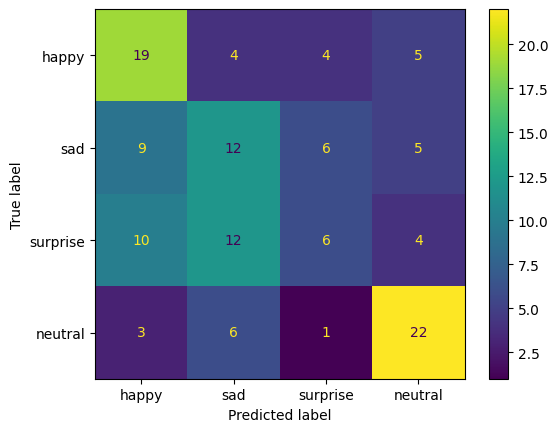

In [80]:
plot_confusion_matrix(vgg_model_2)

**Observations and Insights:**

* The model is most sure about neutral emotion just like the other models.
* The surprise emotion has the lowest f1-score but the score.

## **ResNet V2 Model**

### **Importing the ResNet V2 Architecture**

In [81]:
from keras.applications import ResNet50V2
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [82]:
train_set = load_data(training_data, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True, preprocessing_func=resnet_preprocess_input);
test_set = load_data(testing_data, color_mode = 'rgb');
validation_set = load_data(validation_data, color_mode = 'rgb', preprocessing_func=resnet_preprocess_input);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [83]:
reset()

In [84]:
# Load the ResNetV2 model without including the top fully connected layers
base_res_net_model = ResNet50V2(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_res_net_model.trainable = False
base_res_net_model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 26, 26, 64)           0         ['conv1_conv[0][0]']          
                        

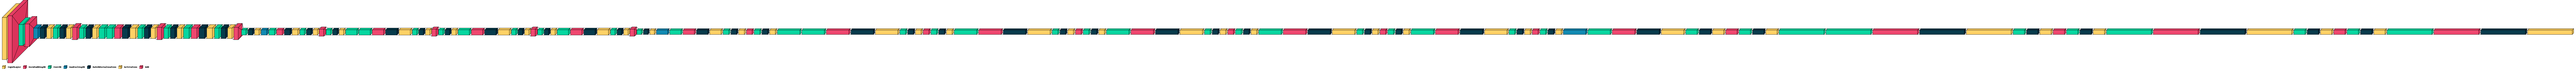

In [85]:
visualkeras.layered_view(base_res_net_model, legend=True)

**Observations and Insights:**

This is a very large model.  So far the largest out of all the other models.

In [86]:
res_net_model = Sequential([
    base_res_net_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
res_net_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

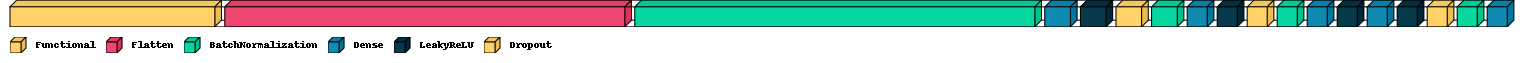

In [87]:
visualkeras.layered_view(res_net_model, legend=True)

### **Compiling and Training the Model**

In [88]:
best_res_net_model = "best_res_net_model.h5"

# Compile model
res_net_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_res_net_model)

# Fit the model to the train dataset
res_net_model_history = res_net_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.4361 - accuracy: 0.3573
Epoch 1: val_accuracy improved from -inf to 0.45750, saving model to best_res_net_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 40s 71ms/step - loss: 1.4361 - accuracy: 0.3573 - val_loss: 1.2503 - val_accuracy: 0.4575
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.4265
Epoch 2: val_accuracy improved from 0.45750 to 0.50854, saving model to best_res_net_model.h5
473/473 [==============================] - 32s 68ms/step - loss: 1.2659 - accuracy: 0.4265 - val_loss: 1.1434 - val_accuracy: 0.5085
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.2145 - accuracy: 0.4566
Epoch 3: val_accuracy improved from 0.50854 to 0.52823, saving model to best_res_net_model.h5
473/473 [==============================] - 32s 68ms/step - loss: 1.2145 - accuracy: 0.4566 - val_loss: 1.1039 - val_accuracy: 0.5282
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.1819 - accuracy: 0.4711
Epoch 4: val_accuracy improved from 0.52823 to 0.55053, saving model to best_res_net_model.h5
473/473 [===================

### **Evaluating the ResNet Model**

In [89]:
# load the best model
res_net_model.load_weights(best_res_net_model)

Maximum Training Accuracy Score: 51.66%
Maximum Validation Accuracy Score: 56.84%


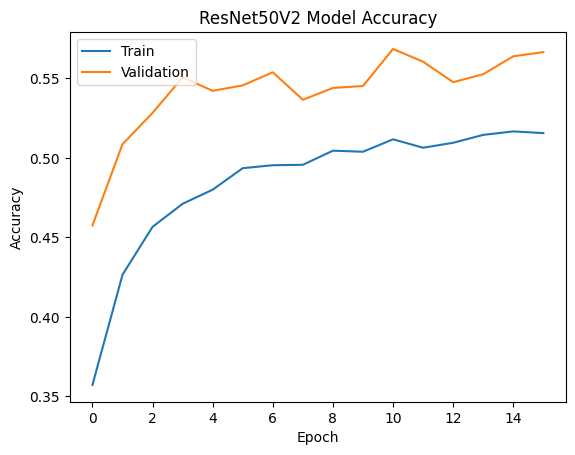

In [90]:
plot_history(res_net_model_history, "ResNet50V2 Model")

In [91]:
# get the accuracy value
accuracy = res_net_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 1.1302 - accuracy: 0.5469 - 53ms/epoch - 13ms/step
Test Accuracy: 54.69%


**Observations and Insights:**

- The ResNet model has an accuracy of 55% on the test data.  Decreasing from the first VGG model's 70%.
- The model is not performing as well as CNN models.



### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

       happy       0.52      0.81      0.63        32
         sad       0.48      0.38      0.42        32
    surprise       0.46      0.38      0.41        32
     neutral       0.74      0.62      0.68        32

    accuracy                           0.55       128
   macro avg       0.55      0.55      0.54       128
weighted avg       0.55      0.55      0.54       128



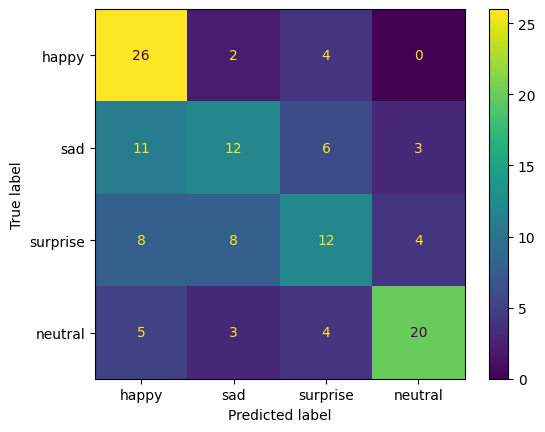

In [92]:
plot_confusion_matrix(res_net_model)

**Observations and Insights:**

- The ResNet model is surest about the neutral emotion.
- It is very unsure about the sad emotion and often confuses it with surprise emotion.


**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

### **Importing the Efficient Model Architecture**

In [117]:
from keras.applications import EfficientNetB0

### **Creating our Data Loaders for Transfer Learning Architectures**

In [94]:
train_set = load_data(training_data, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True);
test_set = load_data(testing_data, color_mode = 'rgb');
validation_set = load_data(validation_data, color_mode = 'rgb');

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [105]:
reset()

In [118]:
# Load the EfficientNet model without including the top fully connected layers
base_efficient_net_model = EfficientNetB0(include_top=False, weights='imagenet', classes=CLASS_COUNT,input_shape=(IMG_SIZE,IMG_SIZE,3))
base_efficient_net_model.trainable = False
base_efficient_net_model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 48, 48, 3)            0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 48, 48, 3)            7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescal

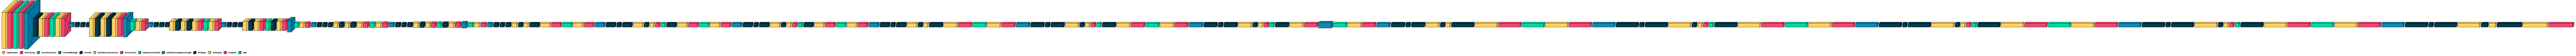

In [119]:
visualkeras.layered_view(base_efficient_net_model, legend=True)

**Observations and Insights:**

The model is even larger than the ResNet model.

In [141]:
efficient_net_model = Sequential([
    base_efficient_net_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
efficient_net_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 256)               327936    
                                                                 
 dense_21 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 4378535 (16.70 MB)
Trainable params: 328964 (1.25 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


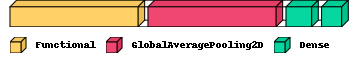

In [142]:
visualkeras.layered_view(efficient_net_model, legend=True)

### **Compiling and Training the Model**

In [143]:
best_efficient_net_model = "best_efficient_net_model.h5"

# Compile model
efficient_net_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_efficient_net_model)

# Fit the model to the train dataset
efficient_net_model_history = efficient_net_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3929 - accuracy: 0.2566
Epoch 1: val_accuracy improved from -inf to 0.22885, saving model to best_efficient_net_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 37s 65ms/step - loss: 1.3929 - accuracy: 0.2566 - val_loss: 1.3811 - val_accuracy: 0.2289
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.3916 - accuracy: 0.2653
Epoch 2: val_accuracy improved from 0.22885 to 0.36669, saving model to best_efficient_net_model.h5
473/473 [==============================] - 30s 62ms/step - loss: 1.3916 - accuracy: 0.2653 - val_loss: 1.3567 - val_accuracy: 0.3667
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.3896 - accuracy: 0.2708
Epoch 3: val_accuracy did not improve from 0.36669
473/473 [==============================] - 29s 62ms/step - loss: 1.3896 - accuracy: 0.2708 - val_loss: 1.4287 - val_accuracy: 0.2289
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.2540
Epoch 4: val_accuracy did not improve from 0.36669
473/473 [==============================] - 29s 62ms/step - loss: 1.3908 - accuracy: 0.2540 - val_loss: 1.360

### **Evaluating the EfficientnetNet Model**

In [144]:
# load the best model
efficient_net_model.load_weights(best_efficient_net_model)

Maximum Training Accuracy Score: 27.08%
Maximum Validation Accuracy Score: 36.67%


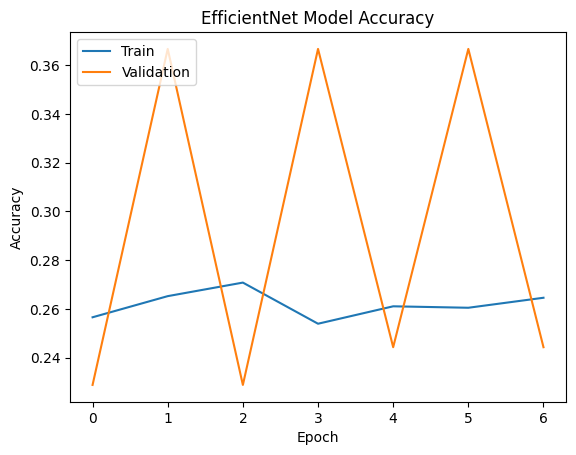

In [145]:
plot_history(efficient_net_model_history, "EfficientNet Model")

In [146]:
# get the accuracy value
accuracy = efficient_net_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 1.4030 - accuracy: 0.2500 - 55ms/epoch - 14ms/step
Test Accuracy: 25.00%


**Observations and Insights:**

- The EfficientNet model has an accuracy of 25% on the test data.
- This is a very poor performing model.
- The model is not performing as well.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

## **Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?



**Previous Models**

| Model      | Training Data Accuracy | Validation Data Accuracy | Test Data Accuracy |
| :--------  | :------------------: | :------------------:| :------------:|
| Grayscale Model  | 61%                 | 70%            | 68%           |
| RGB Model       | 60%                 | 68%             | 73%           |
| CNN Model 2| 62%                 | 68%                 | 66%            |



**Models w/ Transfer Learning**

| Model      | Training Data Accuracy | Validation Data Accuracy | Test Data Accuracy |
| :--------  | :------------------: | :------------------:| :------------:|
| VGG16 Model 1|      47%                 | 52%              | 48%        |
| VGG16 Model 2  | 42%                 | 47%                 | 70%        |
| ResNet V2 Model| 52%                 | 57%                 | 55%        |
| EfficientNet Model | 27%            | 37%                 | 25%         |



  > As you can see in the above table, the **VGG16 Model 2** did not perform as well as the CNN models.  During attempting serveral architectures I noticed that when I made the pre-trained models trainable I got hight accuracies. But not make them trainable and just attaching them to ANN the accuracies where very low.

* Do you think our issue lies with 'rgb' color_mode?
  > I don't think the issue lies with the color mode.  The RGB model was the top performer previous to creating the transfer learning models.  I think the issue lies with fine tuning the models.


Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [164]:
reset()

In [440]:
train_set = load_data(training_data, add_noise=True, augment=True, shuffle=True, color_mode = 'rgb');
test_set = load_data(testing_data, color_mode = 'rgb');
validation_set = load_data(validation_data, color_mode = 'rgb');

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.
Found 4977 validated image filenames belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [206]:
# Initializing the Convolutional Neural Network
cnn_model_3 = Sequential([
    # Convolutional layer with 256 filters, each of size 3x3, using ReLU activation
    Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    LeakyReLU(alpha=0.1), # adding non-linearity and mitigage dying ReLU problem
    Conv2D(64, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    Flatten(), # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Dense(64, activation='relu'),  # a fully connected with 64 nodes as the dense layer
    Dense(32, activation='relu'),  # a fully connected with 32 nodes as the dense layer
    Dense(16, activation='relu'),  # a fully connected with 16 nodes as the dense layer
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

cnn_model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 256)       7168      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 48, 48, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        147520    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                      

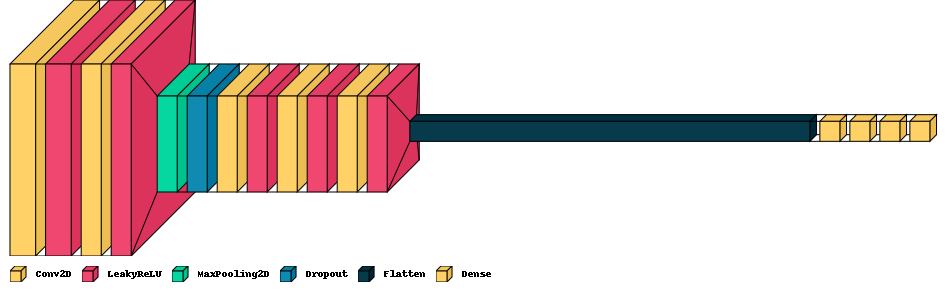

In [167]:
visualkeras.layered_view(cnn_model_3, legend=True)

### **Compiling and Training the Model**

In [168]:
best_cnn_model_3 = "best_cnn_model_3.h5"

# compile the model
cnn_model_3.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# get callbacks
es, mc = get_callbacks(best_cnn_model_3)

# fit the model to the train dataset
cnn_model_3_history = cnn_model_3.fit(train_set,
                                            validation_data = validation_set,
                                            verbose = 1,
                                            epochs = 100,
                                            callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.2704
Epoch 1: val_accuracy improved from -inf to 0.37050, saving model to best_cnn_model_3.h5
473/473 [==============================] - 31s 61ms/step - loss: 1.3784 - accuracy: 0.2704 - val_loss: 1.3652 - val_accuracy: 0.3705
Epoch 2/100
  1/473 [..............................] - ETA: 36s - loss: 1.3819 - accuracy: 0.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.3677 - accuracy: 0.3007
Epoch 2: val_accuracy did not improve from 0.37050
473/473 [==============================] - 29s 61ms/step - loss: 1.3677 - accuracy: 0.3007 - val_loss: 1.3996 - val_accuracy: 0.2467
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.3612 - accuracy: 0.3150
Epoch 3: val_accuracy improved from 0.37050 to 0.37814, saving model to best_cnn_model_3.h5
473/473 [==============================] - 29s 62ms/step - loss: 1.3612 - accuracy: 0.3150 - val_loss: 1.3165 - val_accuracy: 0.3781
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.3475
Epoch 4: val_accuracy did not improve from 0.37814
473/473 [==============================] - 29s 61ms/step - loss: 1.3254 - accuracy: 0.3475 - val_loss: 1.3154 - val_accuracy: 0.3380
Epoch 5/100
473/473 [==============================] - ETA: 0s - loss: 1.2729 - accuracy: 0.3849
Epoch 5: val_accuracy improved 

### **Evaluating the Model on Test Set**

In [438]:
# load the best model
cnn_model_3.load_weights(best_cnn_model_3)

Maximum Training Accuracy Score: 68.97%
Maximum Validation Accuracy Score: 72.92%


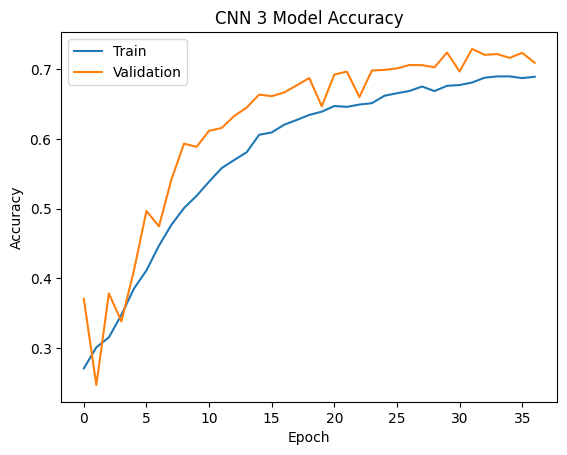

In [170]:
plot_history(cnn_model_3_history, "CNN 3 Model")

In [171]:
# get the accuracy value
accuracy = cnn_model_3.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.5878 - accuracy: 0.7344 - 36ms/epoch - 9ms/step
Test Accuracy: 73.44%


**Observations and Insights:**

- The CNN model 3 has an accuracy of 73% on the test data.
- The top performaing epoch was epoch 33 with a 72% accuracy on the validation data.
- This is the best performing model.  I would suggest using this one.

### **Plotting the Confusion Matrix for the chosen final model**

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       happy       0.72      0.88      0.79        32
         sad       0.62      0.56      0.59        32
    surprise       0.67      0.69      0.68        32
     neutral       0.96      0.81      0.88        32

    accuracy                           0.73       128
   macro avg       0.74      0.73      0.73       128
weighted avg       0.74      0.73      0.73       128



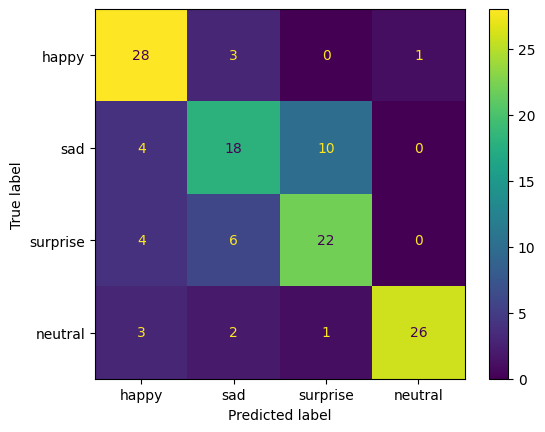

In [172]:
plot_confusion_matrix(cnn_model_3)

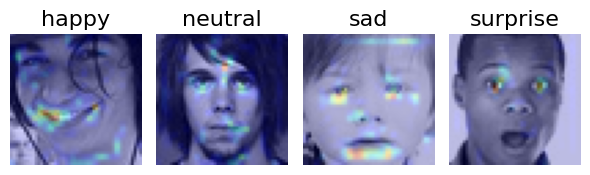

In [443]:
visualize_important_features(cnn_model_3, "conv2d_9")

**Observations and Insights:**

- Like all the previous models, the model is surest about the neutral emotion.
- The model is also the most unsure about the sad emotion, it confuses it with the surprise emotion.  Although not as often as most of the other models.
- As I figured the model is focusing on the mouths and eyes in the images.
- This would be a reason most of the models confused sad eyes with happy eyes.
- It's great to see that the model is focusing on faces and the features that make since to the categories.

## **Conclusion:**

**Models Sorted by Performance**



| Model      | Training Data Accuracy | Validation Data Accuracy | Test Data Accuracy |
| :--------  | :------------------: | :------------------:| :------------:|
| CNN Model 3      | 69%                 | 73%            | 73%           |
| RGB Model       | 60%               | 68%                 | 73%         |
| VGG16 Model 2  | 42%                 | 47%              | 70%           |
| Grayscale Model  | 61%                 | 70%              | 68%         |
| CNN Model 2| 62%                 | 68%                 | 66%            |
| ResNet V2 Model| 52%                 | 57%                 | 55%        |
| VGG16 Model 1|      47%                 | 53%              | 48%        |
| EfficientNet Model | 27%            | 37%                 | 25%         |


### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
  - Neutral emotions are easier to categorize compared to others.
  - Sadness, surprise, and happiness can exhibit similarities, especially in the eyes.
  - Surprise emotions, characterized by the mouth, were expected to be easier to classify but consistently ranked second to neutral.
### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
  - Transfer learning did not yield the expected results. Through experimentation, it became evident that retraining the pre-trained models on our data led to significantly higher accuracies.
  - The simpler approach of creating a CNN with multiple layers demonstrated good performance.
  - Converting the color mode from grayscale to RGB resulted in a slight increase in performance.
  - I believe that fine-tuning a CNN model has the potential to further enhance performance.


### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
  - I propose adopting CNN Model 3 as the final choice. It has demonstrated superior performance, achieving the highest accuracies across the board, including the best accuracy on unseen data.